In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
import cv2
from tqdm.notebook import tqdm

# Initialize lists for images and labels
X = []
y = []

# Load images with tumor ('yes' folder)
os.chdir(r"/content/drive/MyDrive/Data/MRIData/yes")
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(1)  # Label for images with tumors

# Load images without tumor ('no' folder)
os.chdir(r"/content/drive/MyDrive/Data/MRIData/no")
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(0)  # Label for images without tumors


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=2)

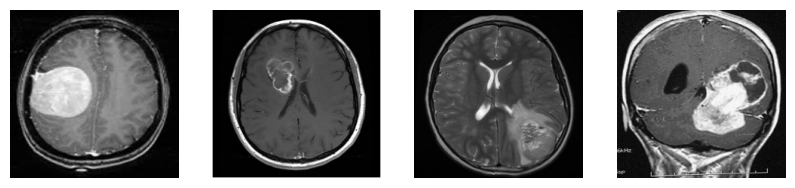

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4,i+1)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
num_classes = 2

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dropout(0.5)(top_model)  # 50% dropout
top_model = Dense(1024, activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(num_classes, activation='softmax')(top_model)

In [ ]:
model = Model(inputs=base_model.input, outputs=top_model)

# Compile the model with an Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
print(model.summary())

# Train the model with callbacks for optimization
history = model.fit(
    X_train, y_train,
    epochs=30,  # Set a higher number of epochs with early stopping
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


<Figure size 640x480 with 0 Axes>

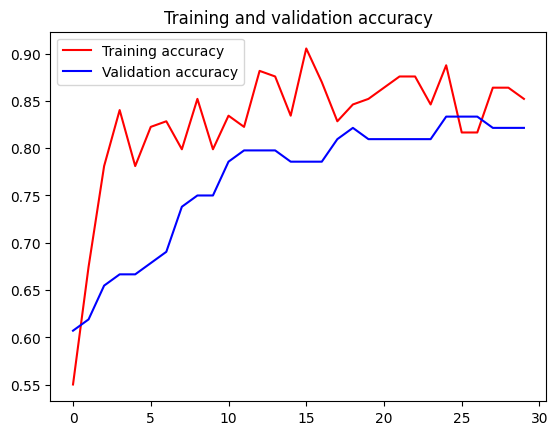

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

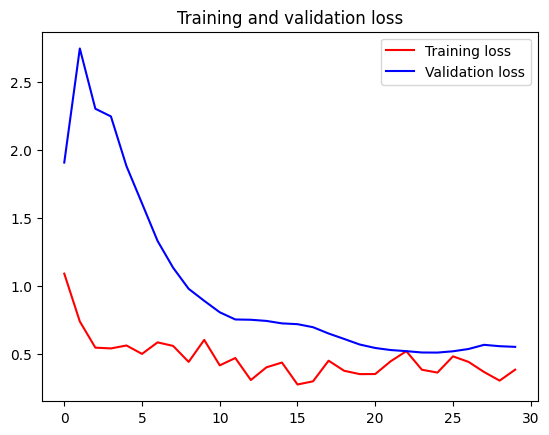

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.applications import vgg16

def predict_image(img_path, model):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = vgg16.preprocess_input(img_array)  # Use VGG-specific preprocessing

    # Predict
    prediction = model.predict(img_array)
    print("Raw prediction probabilities:", prediction)

    # Use threshold if needed
    predicted_class = np.argmax(prediction, axis=1)

    if predicted_class[0] == 1:  # Check if 0 corresponds to "tumor" or "no tumor"
        return "Tumor detected"
    else:
        return "No tumor detected"

# Test prediction
img_path = r'/content/drive/MyDrive/Data/MRIData/no/11 no.jpg'
result = predict_image(img_path, model)
print(result)


1/1 [==============================] - 0s 80ms/step
Raw prediction probabilities: [[0.7845215 0.2154785]]
No tumor detected


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 [==============================] - 2s 551ms/step - loss: 0.5084 - accuracy: 0.8333
Test Loss: 0.5084
Test Accuracy: 0.8333
